In [13]:
import yaml

In [14]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [3]:
pip install google-cloud-translate


Note: you may need to restart the kernel to use updated packages.


In [52]:
if menu['raster_processing']:
    print('run raster_processing')
    
    import os
    import math
    import csv
    import geopandas as gpd
    import numpy as np
    import rasterio.mask
    import rasterio
    import requests
    from pathlib import Path
    from rasterio.merge import merge
    from os.path import exists
    import zipfile
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    from shutil import copyfile
    import glob
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    from google.cloud import translate_v2 as translate
    import lxml.etree as ET
    import zipfile
    from IPython.display import display
    import pandas as pd
    from shapely.geometry import LineString
    import shutil

run raster_processing


read AOI shapefile


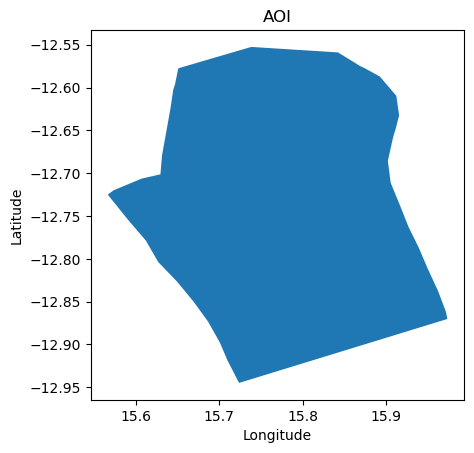

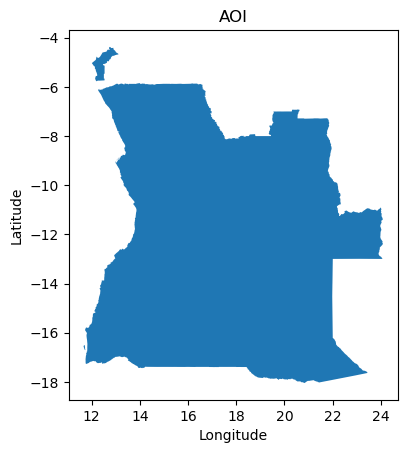

In [5]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans
with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
print('read AOI shapefile')
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry
country_aoi = Path('mnt/city-directories/01-user-input/AOI/Angola.shp')
country_aoi_features = gpd.read_file(country_aoi)
country_features = country_aoi_features.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

fig, ax = plt.subplots()
country_features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Translation was done externally via a text translation converter online

In [6]:
#Import existing infrastructure shapefiles
def plot_existing(existing_data):
    if existing_data is not None:
        # Plot the existing data on Folium map
        m = folium.Map(location=[existing_data['geometry'].centroid.y.mean(), 
                                 existing_data['geometry'].centroid.x.mean()], 
                       zoom_start=10,tiles='CartoDB positron')
        folium.GeoJson(existing_data).add_to(m)
        folium.GeoJson(country_features, style_function=lambda x: {'color': 'red'}).add_to(m)
        print("Existing data plotted successfully.")
        return m
    else:
        print("No existing data to plot.")
        return None

def get_existing(output_folder):
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Get city inputs
    city_inputs = global_inputs.get('city_inputs')

    if menu['existing']:
        existing_file_path = os.path.join(output_folder, "existinggrid.geojson") #downloaded 
        if os.path.exists(existing_file_path):
            existing = gpd.read_file(existing_file_path)
            existing = existing.to_crs(epsg=4326)
            return plot_existing(existing)
        else:
            print("Existing file does not exist.")
            return None
    else:
        return None
    
existing_map = get_existing(output_folder)
if existing_map is not None:
    display(existing_map)



Existing data plotted successfully.


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_10675/1920222595.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[existing_data['geometry'].centroid.y.mean(),
/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_10675/1920222595.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  existing_data['geometry'].centroid.x.mean()],


In [8]:
#get component shapefiles and turn that into a csv with the list of names


def find_shapefiles_in_folders(root_folder):
    shapefiles = []
    for folder_path, _, _ in os.walk(root_folder):
        folder_shapefiles = glob.glob(os.path.join(folder_path, "*.shp"))
        shapefile_names = [os.path.splitext(os.path.basename(shp))[0] for shp in folder_shapefiles]
        shapefiles.extend(shapefile_names)
    return shapefiles

def write_to_csv(shapefile_names, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Shapefile Names"])
        for name in shapefile_names:
            writer.writerow([name])

if __name__ == "__main__":
    root_folder = "mnt/city-directories/02-process-output/Infrastructure/Shapefiles"  # Replace with the root folder containing subfolders with shapefiles
    output_csv = "mnt/city-directories/03-render-output/shapefilelist.csv"  # Specify the output CSV file
    
    shapefile_names = find_shapefiles_in_folders(root_folder)
    
    write_to_csv(shapefile_names, output_csv)


In [48]:


def find_shapefiles_with_keywords(root_folder, keywords):
    shapefiles = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.shp') and any(keyword in file for keyword in keywords):
                shapefiles.append(os.path.join(root, file))
    return shapefiles

def merge_shapefiles(shapefiles, output_file):
    if not shapefiles:
        print("No shapefiles found with the specified keywords.")
        return
    
    # Read each shapefile and merge them into a single GeoDataFrame
    gdf_list = []
    for shapefile in shapefiles:
        gdf = gpd.read_file(shapefile)
        gdf_list.append(gdf)
    
    merged_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)
    
    # Save the merged shapefile
    merged_gdf.to_file(output_file)
    print("Merged shapefile saved as", output_file)

# Example usage
root_folder = 'mnt/city-directories/02-process-output/Infrastructure/Shapefiles'
keywords = ['PTs', 'PT']  # Keywords for identifying relevant shapefiles
output_file = 'mnt/city-directories/03-render-output/merged_shapefile_PTs'

shapefiles = find_shapefiles_with_keywords(root_folder, keywords)
merge_shapefiles(shapefiles, output_file)

#Stations
keywords_station = ['Stations', 'Substations']  # Keywords for identifying relevant shapefiles
output_file_station = 'mnt/city-directories/03-render-output/merged_shapefile_station.shp'

shapefiles_station = find_shapefiles_with_keywords(root_folder, keywords_station)
merge_shapefiles(shapefiles_station, output_file_station)


Merged shapefile saved as mnt/city-directories/03-render-output/merged_shapefile_PTs
Merged shapefile saved as mnt/city-directories/03-render-output/merged_shapefile_station.shp


Manually merge corrupted linestrings

In [58]:
#copy and save all linestring files to a different folder, save 15kv and 30kv files separately in QGIS #All files need to be not corrupted if they are to be merged in python

def find_shapefiles_with_keywords(root_folder, keywords):
    """
    Find shapefiles containing specified keywords in the root folder.
    """
    shapefiles = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.shp') and any(keyword in file for keyword in keywords):
                shapefiles.append(os.path.join(root, file))
    return shapefiles

def copy_shapefiles_to_folder(shapefiles, output_folder):
    """
    Copy shapefiles to the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for shapefile in shapefiles:
        shapefile_name = os.path.basename(shapefile)
        output_shapefile_folder = os.path.join(output_folder, os.path.basename(os.path.dirname(shapefile)))
        if not os.path.exists(output_shapefile_folder):
            os.makedirs(output_shapefile_folder)
        
        # Copy the main .shp file
        shutil.copy(shapefile, output_shapefile_folder)
        print(f"Shapefile '{shapefile_name}' copied to '{output_shapefile_folder}'")

        # Copy associated files (.shx, .prj, .dbf, etc.)
        for ext in ['.shx', '.prj', '.dbf', '.cpg', '.qpj']:
            associated_file = os.path.splitext(shapefile)[0] + ext
            if os.path.exists(associated_file):
                shutil.copy(associated_file, output_shapefile_folder)
                print(f"Associated file '{os.path.basename(associated_file)}' copied to '{output_shapefile_folder}'")

root_folder = 'mnt/city-directories/02-process-output/Infrastructure/Shapefiles'
keywords = ['Lines', 'Line', 'Linha', 'LinesMT']  # Update with your desired keywords for LineString features
output_folder = 'mnt/city-directories/03-render-output/Lines'  # Update with the path to your output folder
shapefiles = find_shapefiles_with_keywords(root_folder, keywords)
copy_shapefiles_to_folder(shapefiles, output_folder)

Shapefile 'January 2024 Benguela Expansion Rehabilition MT Lines Expansion.shp' copied to 'mnt/city-directories/03-render-output/Lines/Janeiro'
Associated file 'January 2024 Benguela Expansion Rehabilition MT Lines Expansion.shx' copied to 'mnt/city-directories/03-render-output/Lines/Janeiro'
Associated file 'January 2024 Benguela Expansion Rehabilition MT Lines Expansion.prj' copied to 'mnt/city-directories/03-render-output/Lines/Janeiro'
Associated file 'January 2024 Benguela Expansion Rehabilition MT Lines Expansion.dbf' copied to 'mnt/city-directories/03-render-output/Lines/Janeiro'
Associated file 'January 2024 Benguela Expansion Rehabilition MT Lines Expansion.cpg' copied to 'mnt/city-directories/03-render-output/Lines/Janeiro'
Shapefile 'Line 30kV Batch 1.shp' copied to 'mnt/city-directories/03-render-output/Lines/Batch 1'
Associated file 'Line 30kV Batch 1.shx' copied to 'mnt/city-directories/03-render-output/Lines/Batch 1'
Associated file 'Line 30kV Batch 1.prj' copied to 'mnt

Manually merge 15kv, 30kv and all lines